 # Check how the distribution of propagation directions from the mesocyclones in CTRL and PGW changes

In [1]:
import cartopy.crs as ccrs
from geopy import distance
from glob import glob
import json
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

path_supercells_present = '/storage/workspaces/giub_meteo_impacts/ci01/supercell_climate/SDT2_output/current_climate/domain/XPT_1MD_zetath5_wth5/supercell*.json'
path_supercells_future = '/storage/workspaces/giub_meteo_impacts/ci01/supercell_climate/SDT2_output/future_climate/domain/XPT_1MD_zetath5_wth5/supercell*.json'

supercell_days_present = glob(path_supercells_present)
supercell_days_future = glob(path_supercells_future)

In [2]:
rp = ccrs.RotatedPole(pole_longitude = -170, pole_latitude = 43)

def lat_lon_to_y_x(lat, lon):
    min_rlat, max_rlat, min_rlon, max_rlon = -14.86, 15.96, -18.86, 11.96
    min_x, max_x, min_y, max_y = 0, 1541, 0, 1541
    rlon, rlat = rp.transform_point(lon, lat, src_crs = ccrs.PlateCarree())
    
    y = (max_y - min_y) / (max_rlat - min_rlat) * (rlat - min_rlat)
    x = (max_x - min_x) / (max_rlon - min_rlon) * (rlon - min_rlon)
    
    return y, x

def get_propagation_vector(meso, now):
    propagations_x, propagations_y = [], []
    cell_index = meso["cell_datelist"].index(now)
    cell_indices = np.arange(cell_index - 6, cell_index + 7, 1)
    cell_indices = cell_indices[cell_indices >= 0]
    cell_indices = cell_indices[cell_indices < len(meso['cell_datelist'])]
    for i in cell_indices[:-1]:
        cell_y_minus, cell_x_minus = lat_lon_to_y_x(meso['cell_lat'][i], meso['cell_lon'][i])
        cell_y_plus, cell_x_plus = lat_lon_to_y_x(meso['cell_lat'][i + 1], meso['cell_lon'][i + 1])
        propagation_x = cell_x_plus - cell_x_minus
        propagation_y = cell_y_plus - cell_y_minus
        
        propagation_norm = np.linalg.norm((propagation_x, propagation_y))

        if propagation_norm != 0:
            propagation_x /= propagation_norm
            propagation_y /= propagation_norm
        else:
            propagation_x, propagation_y = 0, 0
        
        propagations_x += [propagation_x]
        propagations_y += [propagation_y]
        
    propagation_x = np.sum(propagations_x) / len(propagations_x)
    propagation_y = np.sum(propagations_y) / len(propagations_y)
    
    return propagation_x, propagation_y

In [3]:
angles_present = {'left': [], 'right': []}
angles_future = {'left': [], 'right': []}

for day in tqdm(supercell_days_present):
    with open(day, 'r') as supercell_file:
        supercells = json.load(supercell_file)['supercell_data']
        for supercell in supercells:
            for time, sign in zip(supercell['meso_datelist'], supercell['signature']):
                sign = 'right' if sign == 1 else 'left'
                propagation_x, propagation_y = get_propagation_vector(supercell, time)
                angle = np.arctan2(propagation_y, propagation_x)
                angles_present[sign].append(angle)
                
for day in tqdm(supercell_days_future):
    with open(day, 'r') as supercell_file:
        supercells = json.load(supercell_file)['supercell_data']
        for supercell in supercells:
            for time, sign in zip(supercell['meso_datelist'], supercell['signature']):
                sign = 'right' if sign == 1 else 'left'
                propagation_x, propagation_y = get_propagation_vector(supercell, time)
                angle = np.arctan2(propagation_y, propagation_x)
                angles_future[sign].append(angle)

100%|██████████| 2684/2684 [01:09<00:00, 38.81it/s]


In [4]:
# Convert angles for both right and left movers from radians to degrees
angles_present_deg = {
    'left': np.degrees(angles_present['left']),
    'right': np.degrees(angles_present['right'])
}
angles_future_deg = {
    'left': np.degrees(angles_future['left']),
    'right': np.degrees(angles_future['right'])
}

# Adjust negative angles to be in the range [0, 360)
angles_present_deg['left'][angles_present_deg['left'] < 0] += 360
angles_present_deg['right'][angles_present_deg['right'] < 0] += 360

angles_future_deg['left'][angles_future_deg['left'] < 0] += 360
angles_future_deg['right'][angles_future_deg['right'] < 0] += 360

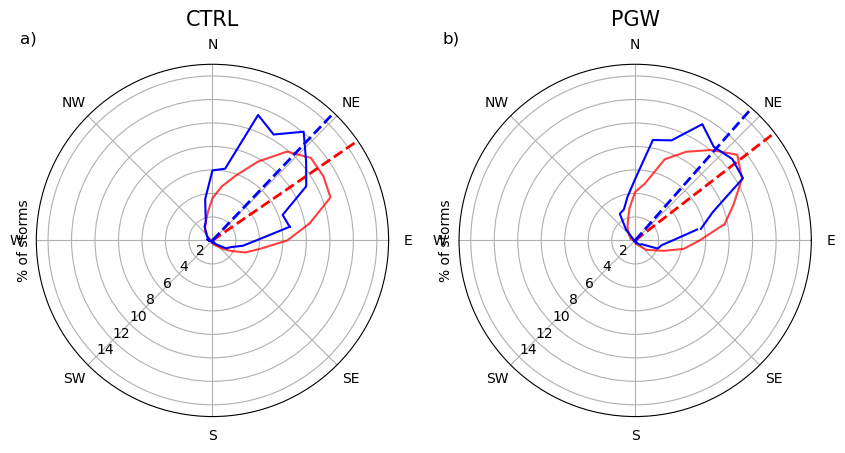

In [ ]:
bins = np.arange(0, 361, 10)

# Calculate histograms for each key ('left' and 'right') in the dictionaries
counts_present = {
    'left': np.append(np.histogram(angles_present_deg['left'], bins = bins)[0],np.histogram(angles_present_deg['left'], bins = bins)[0][0]),
    'right': np.append(np.histogram(angles_present_deg['right'], bins = bins)[0],np.histogram(angles_present_deg['right'], bins = bins)[0][0]),
}
counts_future = {
    'left': np.append(np.histogram(angles_future_deg['left'], bins = bins)[0],np.histogram(angles_present_deg['left'], bins = bins)[0][0]),
    'right': np.append(np.histogram(angles_future_deg['right'], bins = bins)[0],np.histogram(angles_present_deg['right'], bins = bins)[0][0]),
}
bins = np.append(bins,370)
# counts_present = np.append(theta, theta[0])
# r_closed = np.append(r, r[0])

# Bin edges are the same for all histograms
bin_edges = np.histogram(angles_present_deg['left'], bins = bins)[1]  # Can use any histogram result

bins_rad = np.deg2rad(bins[1:])

fig, axes = plt.subplots(1, 2, subplot_kw = {'projection': 'polar'}, figsize = (10, 5))
colors = ['#1F63A8', '#E32F27']  
for i, ax in enumerate(axes):
    r = counts_present['right'] if i == 0 else counts_future['right']
    r = 100*r/np.nansum(r[:-1])
    theta = bins_rad
    mean_dir = np.rad2deg(np.arctan2(np.sum(np.sin(theta) * r), np.sum(np.cos(theta) * r))) % 360
    ax.plot([np.deg2rad(mean_dir), np.deg2rad(mean_dir)],
         [0, 15], color='##E32F27',linestyle='--', linewidth=2, label='Mean direction')
    ax.plot(bins_rad, r, color = '##E32F27' if i == 0 else '##E32F27', alpha = 0.75)
    r = counts_present['left'] if i == 0 else counts_future['left']
    r = 100*r/np.nansum(r[:-1])
    theta = bins_rad
    mean_dir = np.rad2deg(np.arctan2(np.sum(np.sin(theta) * r), np.sum(np.cos(theta) * r))) % 360
    ax.plot([np.deg2rad(mean_dir), np.deg2rad(mean_dir)],
         [0, 15], color='#1F63A8',linestyle='--', linewidth=2, label='Mean direction')
    ax.plot(bins_rad, r, color = '#1F63A8' if i == 0 else '#1F63A8', alpha = 1)
    ax.set_xticks(np.deg2rad([0, 45, 90, 135, 180, 225, 270, 315]))  # Positions for the cardinal directions
    ax.set_xticklabels(['E', 'NE', 'N', 'NW', 'W', 'SW', 'S', 'SE'])  # Corresponding labels
    #ax.set_ylabel('% of storms')
    ax.set_rlabel_position(225)  # Move radial labels away from plotted line
    ax.grid(True)
    ax.set_ylim(0, 15)
    ax.set_title("CTRL" if i == 0 else "PGW", va = 'bottom', fontsize = 15)
    
labels = ['a)', 'b)']
for i, ax in enumerate(axes):
    ax.annotate(labels[i], xy = (0, 1), xycoords = 'axes fraction', xytext = (-1, 2), textcoords = 'offset fontsize', fontsize = 12, verticalalignment = 'top', bbox = dict(facecolor = '1.0', edgecolor = 'none', boxstyle = 'square, pad = 0.2'), zorder = 10)
    
plt.savefig(fname = 'polar_propagation_directions.png', format = 'png', bbox_inches = 'tight', dpi = 400)

In [3]:
bins = np.arange(0, 361, 10)

# Calculate histograms for each key ('left' and 'right') in the dictionaries
counts_present = {
    'left': np.append(np.histogram(angles_present_deg['left'], bins = bins)[0],np.histogram(angles_present_deg['left'], bins = bins)[0][0]),
    'right': np.append(np.histogram(angles_present_deg['right'], bins = bins)[0],np.histogram(angles_present_deg['right'], bins = bins)[0][0]),
}
counts_future = {
    'left': np.append(np.histogram(angles_future_deg['left'], bins = bins)[0],np.histogram(angles_present_deg['left'], bins = bins)[0][0]),
    'right': np.append(np.histogram(angles_future_deg['right'], bins = bins)[0],np.histogram(angles_present_deg['right'], bins = bins)[0][0]),
}
bins = np.append(bins,370)
# counts_present = np.append(theta, theta[0])
# r_closed = np.append(r, r[0])

# Bin edges are the same for all histograms
bin_edges = np.histogram(angles_present_deg['left'], bins = bins)[1]  # Can use any histogram result

bins_rad = np.deg2rad(bins[1:])

fig, ax = plt.subplots(1, 1, subplot_kw = {'projection': 'polar'}, figsize = (5, 5))
colors = ['#1F63A8', '#E32F27']  
for i in [0,1]:
    r = counts_present['right'] if i == 0 else counts_future['right']
    r = 100*r/np.nansum(r[:-1])
    theta = bins_rad
    mean_dir = np.rad2deg(np.arctan2(np.sum(np.sin(theta) * r), np.sum(np.cos(theta) * r))) % 360
    print(mean_dir)
    ax.plot([np.deg2rad(mean_dir), np.deg2rad(mean_dir)],
         [0, 15], color='#E32F27', linestyle='-' if i == 0 else '--', linewidth=2, label='CC - RM' if i == 0 else 'PGW - RM')
    ax.plot(bins_rad, r, color='#E32F27',linestyle='-' if i == 0 else '--', alpha = 0.75)
    r = counts_present['left'] if i == 0 else counts_future['left']
    r = 100*r/np.nansum(r[:-1])
    theta = bins_rad
    mean_dir = np.rad2deg(np.arctan2(np.sum(np.sin(theta) * r), np.sum(np.cos(theta) * r))) % 360
    print(mean_dir)
    ax.plot([np.deg2rad(mean_dir), np.deg2rad(mean_dir)],
         [0, 15], color='#1F63A8', linestyle='-' if i == 0 else '--', linewidth=2, label='CC - LM' if i == 0 else 'PGW - LM')
    ax.plot(bins_rad, r, color='#1F63A8',linestyle='-' if i == 0 else '--', alpha = 1)
ax.set_xticks(np.deg2rad([0, 45, 90, 135, 180, 225, 270, 315]))  # Positions for the cardinal directions
ax.set_xticklabels(['E', 'NE', 'N', 'NW', 'W', 'SW', 'S', 'SE'])  # Corresponding labels
#ax.set_ylabel('% of storms',rotation=45)
ax.text(np.deg2rad(245), 10, '% of storms',
    rotation=45,                # no rotation
    ha='center', va='bottom',  # align nicely
    fontsize=10)
ax.set_rlabel_position(225)  # Move radial labels away from plotted line
ax.grid(True)
ax.set_ylim(0, 15)
# ax.legend()
ax.set_title("(a) propagation directions", va = 'bottom', fontsize = 15)


plt.savefig(fname = 'polar_propagation_directions.png', format = 'png', bbox_inches = 'tight', dpi = 400)

NameError: name 'angles_present_deg' is not defined

# The following part is to get the mean propagation velocity of all supercell tracks

In [3]:

velocities_present = {'left': [], 'right': []}
velocities_future = {'left': [], 'right': []}

distances = []

for day in tqdm(supercell_days_present):
    with open(day, 'r') as supercell_file:
        supercells = json.load(supercell_file)['supercell_data']
        for supercell in supercells:
            for time, sign in zip(supercell['meso_datelist'], supercell['signature']):
                sign = 'right' if sign == 1 else 'left'
                cell_lat, cell_lon = supercell['cell_lat'][1:-1], supercell['cell_lon'][1:-1]
                padded = np.pad(cell_lat, pad_width=5//2, mode='edge')
                cell_lat = np.convolve(padded,np.ones(5)/5,mode='valid')
                padded = np.pad(cell_lon, pad_width=5//2, mode='edge')
                cell_lon = np.convolve(padded,np.ones(5)/5,mode='valid')
                for i in range(len(cell_lat) - 1):
                    pt1 = (cell_lat[i], cell_lon[i])
                    pt2 = (cell_lat[i + 1], cell_lon[i + 1])
                    distances += [distance.distance(pt2, pt1).m]
                velocities_present[sign].append([distance / (5 * 60) for distance in distances if distance<10000])
                distances = []
       

100%|██████████| 2684/2684 [00:52<00:00, 51.29it/s]


In [4]:
         
for day in tqdm(supercell_days_future):
    with open(day, 'r') as supercell_file:
        supercells = json.load(supercell_file)['supercell_data']
        for supercell in supercells:
            for time, sign in zip(supercell['meso_datelist'], supercell['signature']):
                sign = 'right' if sign == 1 else 'left'
                cell_lat, cell_lon = supercell['cell_lat'], supercell['cell_lon']
                padded = np.pad(cell_lat, pad_width=5//2, mode='edge')
                cell_lat = np.convolve(padded,np.ones(5)/5,mode='valid')
                padded = np.pad(cell_lon, pad_width=5//2, mode='edge')
                cell_lon = np.convolve(padded,np.ones(5)/5,mode='valid')
                for i in range(len(cell_lat) - 1):
                    pt1 = (cell_lat[i], cell_lon[i])
                    pt2 = (cell_lat[i + 1], cell_lon[i + 1])
                    distances += [distance.distance(pt2, pt1).m]
                # distances = distances[distances<10000]
                velocities_future[sign].append([distance / (5 * 60) for distance in distances if distance<10000])
                distances = []


100%|██████████| 2684/2684 [00:59<00:00, 45.43it/s]


In [5]:
print(cell_lat)
print(cell_lon)
padded = np.pad(cell_lat, pad_width=5//2, mode='edge')
cell_lat = np.convolve(padded,np.ones(5)/5,mode='valid')
print(cell_lat)

[38.0562 38.0366 38.0468 38.0518 38.1222 38.1756 38.2376 38.2734 38.3176
 38.3192 38.2906 38.2436 38.1898 38.0836 37.985  37.8784 37.783  37.6984
 37.6666 37.6534 37.6792 37.7046 37.726  37.7554 37.7774 37.8028 37.8286
 37.8544 37.8722 37.9012 37.9264 37.9514 37.9768 37.9978 38.0152 38.0324
 38.0494 38.066  38.0904 38.1188 38.1508 38.1828 38.1986 38.2142 38.226
 38.238  38.2458 38.264  38.2746 38.2782 38.2896 38.3134 38.343  38.3804
 38.4174 38.4394]
[17.4706 17.5186 17.5956 17.6872 17.7618 17.8494 17.9282 17.9836 18.035
 18.0656 18.072  18.0558 18.0234 17.9438 17.8706 17.7966 17.734  17.688
 17.684  17.6974 17.7256 17.759  17.7918 17.8258 17.8536 17.887  17.9154
 17.9438 17.9712 18.0104 18.049  18.0876 18.1214 18.1594 18.192  18.2246
 18.2622 18.3048 18.3486 18.393  18.443  18.493  18.4952 18.5024 18.504
 18.5058 18.507  18.5298 18.5466 18.5978 18.6502 18.6992 18.7744 18.851
 18.887  18.9106]
[38.0504  38.04952 38.06272 38.0866  38.1268  38.17212 38.22528 38.26468
 38.28768 38.28888 3

In [6]:
from scipy.stats import mannwhitneyu
flat_list1 = [item for sublist in velocities_present['left'] for item in sublist]
print(np.mean(flat_list1))
flat_list2 = [item for sublist in velocities_present['right'] for item in sublist]
print(np.mean(flat_list2) )
print(mannwhitneyu(flat_list1,flat_list2)[1]<=0.05)
flat_list3 = [item for sublist in velocities_future['left'] for item in sublist]
print(np.mean(flat_list3) )
flat_list4 = [item for sublist in velocities_future['right'] for item in sublist]
print(np.mean(flat_list4) )
print(mannwhitneyu(flat_list3,flat_list4)[1]<=0.05)

print(mannwhitneyu(flat_list1,flat_list3)[1]<=0.05)
print(mannwhitneyu(flat_list2,flat_list4)[1]<=0.05)

15.39004857771396
15.189672740706198
True
15.916943243108802
16.043195443722528
True
True
True


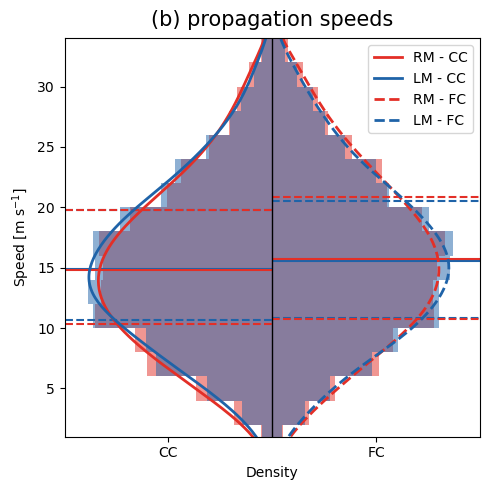

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
colors = ['#1F63A8', '#E32F27'] 
bins = np.arange(0, 35, 2)

# Compute histograms first
hist1, _ = np.histogram(flat_list2, bins=bins, density=True)
hist2, _ = np.histogram(flat_list1, bins=bins, density=True)
hist3, _ = np.histogram(flat_list4, bins=bins, density=True)
hist4, _ = np.histogram(flat_list3, bins=bins, density=True)

bin_centers = 0.5 * (bins[:-1] + bins[1:])

fig, ax = plt.subplots(figsize=(5,5))

# Positive histograms (to the right)
ax.barh(bin_centers, -hist1, height=np.diff(bins), color='#E32F27', alpha=0.5)
ax.barh(bin_centers, -hist2, height=np.diff(bins), color='#1F63A8', alpha=0.5)
ax.hlines(np.nanmedian(flat_list1), -1,0, color='#1F63A8')
ax.hlines(np.nanpercentile(flat_list1,25), -1,0, color='#1F63A8', linestyles='--')
ax.hlines(np.nanpercentile(flat_list1,75), -1,0, color='#1F63A8', linestyles='--')
ax.hlines(np.nanmedian(flat_list2),-1,0, color='#E32F27')
ax.hlines(np.nanpercentile(flat_list2,25), -1,0, color='#E32F27', linestyles='--')
ax.hlines(np.nanpercentile(flat_list2,75), -1,0, color='#E32F27', linestyles='--')

# Negative histograms (mirrored, to the left)
ax.barh(bin_centers, hist3, height=np.diff(bins), color='#E32F27', alpha=0.5)
ax.barh(bin_centers, hist4, height=np.diff(bins), color='#1F63A8', alpha=0.5)
ax.hlines(np.nanmedian(flat_list3),0,1, color='#1F63A8', linestyles='-')
ax.hlines(np.nanpercentile(flat_list3,25), 0,1, color='#1F63A8', linestyles='--')
ax.hlines(np.nanpercentile(flat_list3,75), 0,1, color='#1F63A8', linestyles='--')
ax.hlines(np.nanmedian(flat_list4),0,1, color='#E32F27', linestyles='-')
ax.hlines(np.nanpercentile(flat_list4,25), 0,1, color='#E32F27', linestyles='--')
ax.hlines(np.nanpercentile(flat_list4,75), 0,1, color='#E32F27', linestyles='--')

# --- KDE curves ---
y_eval = np.linspace(0, 35, 200)

# Positive KDE curves
kde1 = gaussian_kde(flat_list2, bw_method=0.3)
kde2 = gaussian_kde(flat_list1, bw_method=0.3)
ax.plot(-kde1(y_eval), y_eval, color='#E32F27', lw=2, label='RM - CC')
ax.plot(-kde2(y_eval), y_eval, color='#1F63A8', lw=2, label='LM - CC')

# Negative KDE curves (mirrored)
kde3 = gaussian_kde(flat_list4, bw_method=0.3)
kde4 = gaussian_kde(flat_list3, bw_method=0.3)
ax.plot(kde3(y_eval), y_eval, color='#E32F27', lw=2, ls='--', label='RM - FC')
ax.plot(kde4(y_eval), y_eval, color='#1F63A8', lw=2, ls='--', label='LM - FC')

# Axes styling
ax.axvline(0, color='black', linewidth=1)  # vertical line at 0
ax.set_ylabel('Speed [m s$^{-1}$]')
ax.set_xticks([-0.0325,0.0325],['CC','FC'])
ax.set_ylim([1,34])
ax.set_xlim([-0.065,0.065])
ax.set_xlabel('Density')
ax.legend(loc='upper right')
ax.set_title("(b) propagation speeds", va = 'bottom', fontsize = 15)

plt.tight_layout()


plt.savefig(fname = 'propagation_speed.png', format = 'png', bbox_inches = 'tight', dpi = 400)
plt.show()
